In [ ]:
!wget https://raw.githubusercontent.com/dphi-official/Datasets/master/auction_data/train_set_label.csv
!wget https://raw.githubusercontent.com/dphi-official/Datasets/master/auction_data/test_set_label.csv

--2020-12-14 07:31:50--  https://raw.githubusercontent.com/dphi-official/Datasets/master/auction_data/train_set_label.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68475 (67K) [text/plain]
Saving to: ‘train_set_label.csv’

train_set_label.csv 100%[===================>]  66.87K  --.-KB/s    in 0.007s  

2020-12-14 07:31:50 (8.74 MB/s) - ‘train_set_label.csv’ saved [68475/68475]

--2020-12-14 07:31:50--  https://raw.githubusercontent.com/dphi-official/Datasets/master/auction_data/test_set_label.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 O

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
train = pd.read_csv('train_set_label.csv')
test = pd.read_csv('test_set_label.csv')
#re=test['auctionid']

In [ ]:
train.head(5)

,auctionid,bid,bidtime,bidder,bidderrate,openbid,price
0,1644594033,493.0,6.999456,boraborabora,67,9.99,498.00
1,1639309309,30.0,1.669618,aclbjc,0,1.00,374.99
2,1644109746,3103.0,6.917986,nelsoncpm,7,1.00,3103.00
3,1649858595,175.0,3.107014,pialu9,4,7.99,202.50
4,1647846714,226.0,2.721319,geemeetee@aol.com,17,1.00,905.45


In [ ]:
test.head(5)

,auctionid,bid,bidtime,bidder,bidderrate,openbid
0,1640550476,175.00,4.329410,simonho2001sg,8,1.0
1,1644343468,111.11,0.587164,tab999@msn.com,84,1.0
2,1639979107,103.50,6.999572,inyerdrms,2,5.0
3,1649718196,620.00,2.750775,kjr2306,24,1.0
4,1644077820,60.00,1.393611,chevysred,-1,1.0


In [ ]:
train.isnull().sum(),test.isnull().sum(),train.shape,test.shape,train.dtypes

(auctionid     0
 bid           0
 bidtime       0
 bidder        0
 bidderrate    0
 openbid       0
 price         0
 dtype: int64, auctionid     0
 bid           0
 bidtime       0
 bidder        0
 bidderrate    0
 openbid       0
 dtype: int64, (1213, 7), (337, 6), auctionid       int64
 bid           float64
 bidtime       float64
 bidder         object
 bidderrate      int64
 openbid       float64
 price         float64
 dtype: object)

In [ ]:
df=pd.concat([train,test])

In [ ]:
df.nunique(), df.isnull().sum(),df.dtypes

(auctionid       97
 bid            536
 bidtime       1318
 bidder         509
 bidderrate     137
 openbid         45
 price           86
 dtype: int64, auctionid       0
 bid             0
 bidtime         0
 bidder          0
 bidderrate      0
 openbid         0
 price         337
 dtype: int64, auctionid       int64
 bid           float64
 bidtime       float64
 bidder         object
 bidderrate      int64
 openbid       float64
 price         float64
 dtype: object)

In [ ]:
x=['bidder']
for i in x:
  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  df[i] = le.fit_transform(df[i])

In [ ]:
train = df[df['price'].isnull()==False]
test = df[df['price'].isnull()==True]
del test['price']

In [ ]:
train_df=train.copy()
test_df=test.copy()

In [ ]:
X = train_df.drop(labels=['price'], axis=1)
y = train_df['price'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.10, random_state=101)

In [ ]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((1091, 6), (1091,), (122, 6), (122,))

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'objective': 'regression',
         'boosting': 'gbdt',  
         'metric': 'l2_root',
         'learning_rate': 0.4, 
         'num_iterations': 3500,
         'num_leaves': 69,
         'max_depth': -1,
         'min_data_in_leaf': 11,
         'bagging_fraction': 0.90,
         'bagging_freq': 1,
         'bagging_seed': 3,
         'feature_fraction': 0.90,
         'feature_fraction_seed': 2,
         'early_stopping_round': 200,
         'max_bin': 500
         }

lgbm = lgb.train(params=param, verbose_eval=100, train_set=train_data, valid_sets=[test_data])

y_pred_lgbm = lgbm.predict(X_cv)
print('RMSLE:', sqrt(mean_squared_error(y_cv, y_pred_lgbm)))

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 72.3579
[200]	valid_0's rmse: 72.3225
Early stopping, best iteration is:
[88]	valid_0's rmse: 71.812
RMSLE: 71.81202796627645


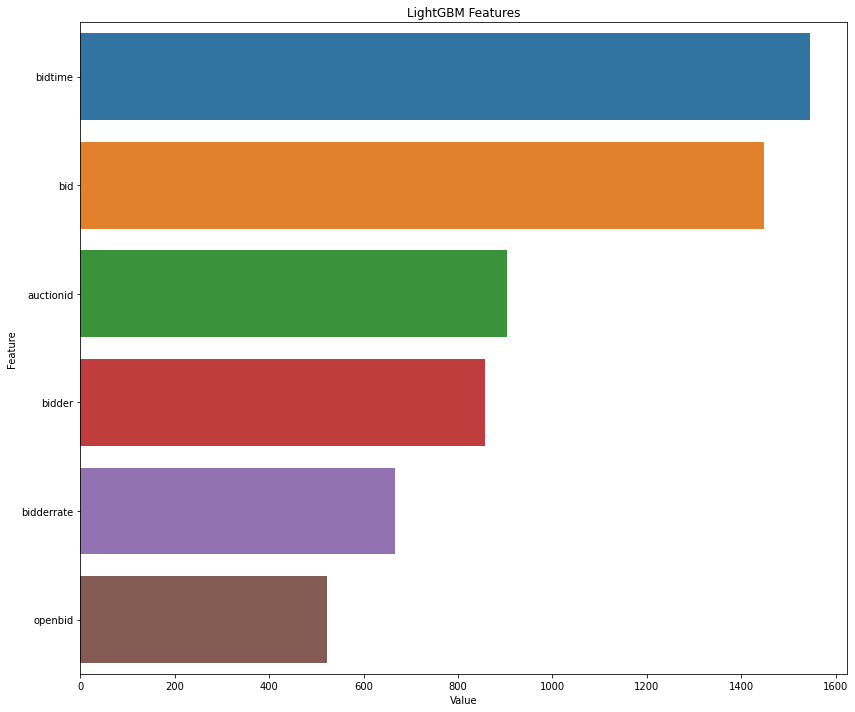

In [ ]:

import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importance(), X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(12, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [ ]:
Xtest = test_df

In [ ]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

errlgb = []
y_pred_totlgb = []

fold = KFold(n_splits=4, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgbm = LGBMRegressor(**param)
    lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200)

    y_pred_lgbm = lgbm.predict(X_test)
    print("RMSLE LGBM: ", sqrt(mean_squared_error(y_test, y_pred_lgbm)))

    errlgb.append(sqrt(mean_squared_error(y_test,y_pred_lgbm)))
    p = lgbm.predict(Xtest)
    y_pred_totlgb.append(p)

RMSLE LGBM:  146.87949836178268
RMSLE LGBM:  211.9906007923924
RMSLE LGBM:  147.356339406803
RMSLE LGBM:  179.47935256911245


In [ ]:
np.mean(errlgb,0)

5.965099968965942

In [ ]:
lgbm_final = (np.mean(y_pred_totlgb,0))

In [ ]:
submission = pd.DataFrame({
        "prediction":  lgbm_final
    })
submission.to_csv('./ddd.csv', index=False)
print(submission)

     prediction
0      312.6913
1     1125.4525
2      116.9382
3     1358.3800
4      431.7028
..          ...
332    411.3302
333    202.5654
334    443.3837
335    648.2007
336    353.0741

[337 rows x 1 columns]
